In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import plotly.express as px
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.optim as optim
from time import time

Open file

In [27]:
file_path = 'Trips_2018.csv'

if not os.path.exists('plots'):
    os.makedirs('plots')

with open(file_path, 'r') as f:
    df = pd.read_csv(f)

Sample the data (can be removed completely later)

In [28]:
df = df.drop(df.columns[0], axis=1) # We are dropping the first coolumn because it is just an index
df = df.sample(n=10000, random_state=42)

Remove null values for start_station_id and end_station_id

In [29]:
df = df[pd.to_numeric(df['start_station_id'], errors='coerce').notnull()]
df = df[pd.to_numeric(df['end_station_id'], errors='coerce').notnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9999 entries, 16303534 to 4635301
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   tripduration             9999 non-null   int64  
 1   starttime                9999 non-null   object 
 2   stoptime                 9999 non-null   object 
 3   start_station_id         9999 non-null   float64
 4   start_station_latitude   9999 non-null   float64
 5   start_station_longitude  9999 non-null   float64
 6   end_station_id           9999 non-null   float64
 7   end_station_latitude     9999 non-null   float64
 8   end_station_longitude    9999 non-null   float64
 9   bikeid                   9999 non-null   int64  
 10  usertype                 9999 non-null   object 
 11  birth_year               9999 non-null   int64  
 12  gender                   9999 non-null   int64  
dtypes: float64(6), int64(4), object(3)
memory usage: 1.1+ MB


Clean up the data

In [30]:
# Convert start_time and end_time columns to datetime format
df['starttime'] = pd.to_datetime(df['starttime'])
df['stoptime'] = pd.to_datetime(df['stoptime'])

# Extract date, hour, and day of the week from start_time column
df['date'] = df['starttime'].dt.date
df['hour'] = df['starttime'].dt.hour
df['day_of_week'] = df['starttime'].dt.dayofweek

# Drop any rows with null values
df = df.dropna()

# Drop any rows with negative trip durations
df = df[df['tripduration'] > 0]

# Drop any rows with trip durations greater than 24 hours
df = df[df['tripduration'] <= 86400]

# Drop rows that are outside the 99th percentile of trip durations
df = df[df['tripduration'] <= df['tripduration'].quantile(.99)]

# Drop rows where the birth_year is outside the lower 99th percentile of birth years
df = df[df['birth_year'] >= df['birth_year'].quantile(.01)]

# Drop rows where the gender is not 0, 1
df = df[df['gender'].isin([0, 1])]

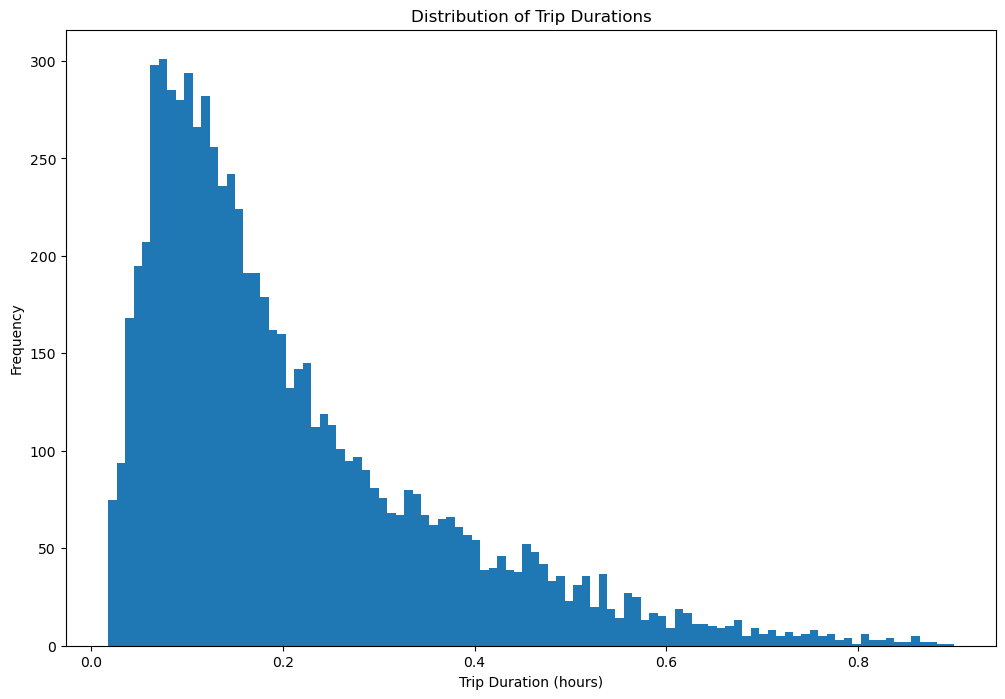

In [31]:
# Distribution of trip durations
plt.figure(figsize=(12, 8))
plt.hist(df['tripduration']/3600, bins=100)
plt.xlabel('Trip Duration (hours)')
plt.ylabel('Frequency')
plt.title('Distribution of Trip Durations')
plt.savefig(os.path.join('plots', 'trip_duration_distribution.png'))
plt.show()


PCA on the data

In [32]:
df['tripduration'] = (df['stoptime'] - df['starttime']).dt.total_seconds()

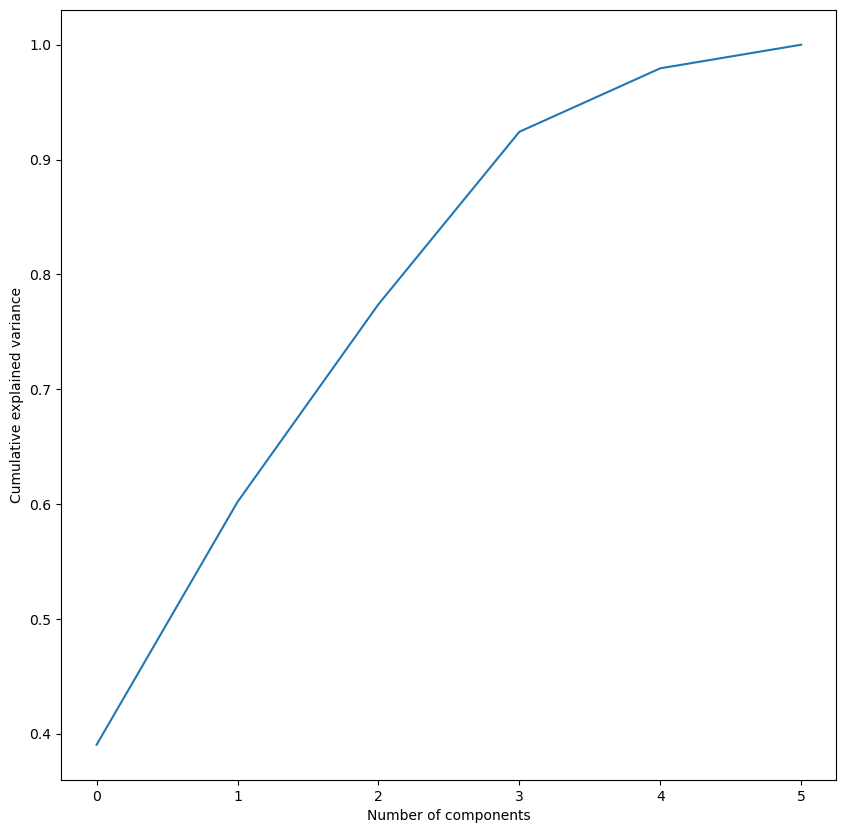


Principal Component 1 Loadings:
end_station_latitude       0.533767
start_station_latitude     0.528324
end_station_longitude      0.469939
start_station_longitude    0.463621
tripduration               0.013096
birth_year                 0.002909
Name: 0, dtype: float64

Principal Component 2 Loadings:
start_station_longitude    0.460150
end_station_longitude      0.452939
birth_year                 0.425099
tripduration              -0.290074
end_station_latitude      -0.394429
start_station_latitude    -0.403339
Name: 1, dtype: float64

Principal Component 3 Loadings:
tripduration               0.717280
start_station_longitude    0.260653
end_station_longitude      0.251145
end_station_latitude      -0.230462
start_station_latitude    -0.234332
birth_year                -0.496459
Name: 2, dtype: float64

Principal Component 4 Loadings:
birth_year                 0.756784
tripduration               0.633354
start_station_latitude     0.078262
end_station_latitude       0.060744
end_

In [33]:
# Standardize the data
scaler = StandardScaler()
scaled_df = scaler.fit_transform(df[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration']])
scaled_df = pd.DataFrame(scaled_df, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])

# PCA using all the features
pca = PCA(n_components=6)
pca.fit(scaled_df)
pca_df = pca.transform(scaled_df)
pca_df = pd.DataFrame(pca.components_, columns=['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'birth_year', 'tripduration'])


plt.figure(figsize=(10, 10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.savefig(os.path.join('plots', 'pca_cumulative_explained_variance.png'))
plt.show()

corr_matrix = scaled_df.corr()
corr_matrix['tripduration'].sort_values(ascending=False)

# Print the loadings for each principal component
for i in range(len(pca_df)):
    print(f"\nPrincipal Component {i + 1} Loadings:")
    print(pca_df.iloc[i].sort_values(ascending=False))


Elbow method

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda

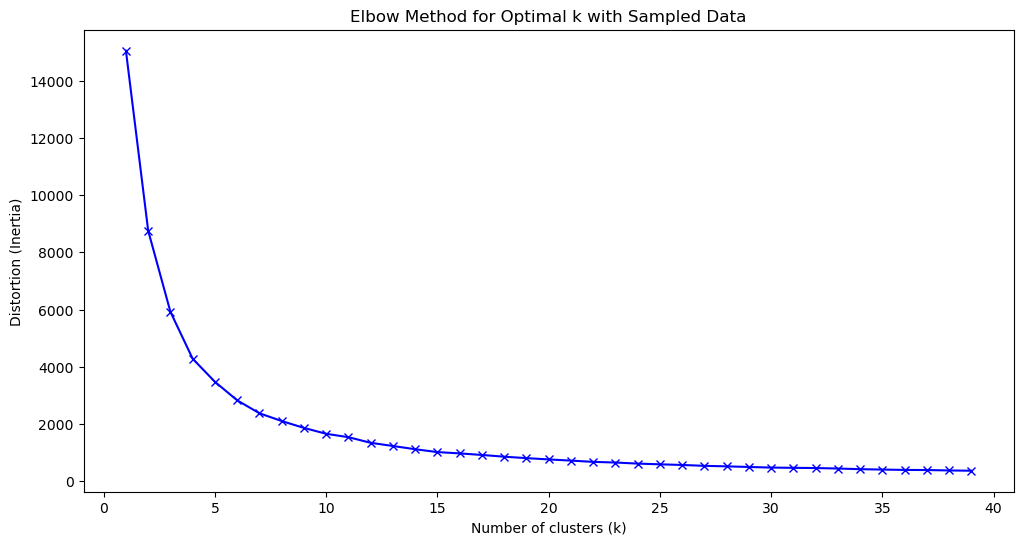

In [34]:
# Extract coordinates from the sample
coordinates_sample = df[['start_station_latitude', 'start_station_longitude']]

#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_sample)
# coordinates_sample = coordinates_standardized

#Elbow method
distortions = []
K = range(1, 40)  
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(coordinates_standardized)
    distortions.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(12, 6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Distortion (Inertia)')
plt.title('Elbow Method for Optimal k with Sampled Data')
plt.show()


Further processing with K-means clustering to remove locations we don't care about

In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Finding the optimal number of clusters with elbow method

# Extract coordinates from the sample
coordinates_start = df[['start_station_latitude', 'start_station_longitude']]
coordinates_end = df[['end_station_latitude', 'end_station_longitude']]

#Standardize the coordinates
scaler = StandardScaler()
coordinates_standardized = scaler.fit_transform(coordinates_start)

# Plot K-means with 20 clusters
kmeans = KMeans(n_clusters=20, random_state=42)
kmeans.fit(coordinates_standardized)
df['cluster'] = kmeans.predict(coordinates_standardized)

# Cluster the data into 20 clusters
kmeans = KMeans(n_clusters=20, init='k-means++', random_state=42).fit(coordinates_start)

# Get the cluster centers
centers = kmeans.cluster_centers_

# Add the cluster labels to the dataframe
df['cluster'] = kmeans.predict(coordinates_start)

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/mike/miniconda3/envs/scientific/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Plot the clusters on a map

In [36]:
import plotly.express as px

def plot_stations_map(stations):
    #First before plotting we have to deal with the outliers 
    #The latitude of New York City is approximately between 40.4774 and 45.01585, and the longitude is approximately between -79.76259 and -71.18507.

    lon_min = -79.76259
    lat_min = 40.4774
    lon_max = -71.18507
    lat_max = 45.01585

    # Store the stations that are within the boundaries
    stations = stations[
        (stations['start_station_latitude'] > lat_min) &
        (stations['start_station_latitude'] < lat_max) &
        (stations['start_station_longitude'] > lon_min) &
        (stations['start_station_longitude'] < lon_max)
    ]
    
    #Plot the stations with an underlying map of New York City
    title = 'Citi Bike Stations in New York City'
    fig = px.scatter_mapbox(
        stations,
        lat='start_station_latitude',
        lon='start_station_longitude',
        color='cluster',
        mapbox_style='carto-positron',
        zoom=9,
        width=1000,
        height=600
    )
    fig.update_layout(
        title=dict(
            text=title,
            x=0.5,  # Center the title horizontally
            xanchor='center',  # Anchor point for horizontal alignment
            font=dict(size=20)
        )
    )
    fig.show()


Remove the locations that are more than 3 standard deviations from the center of the clusters

In [37]:
# Calculate the distance between each point and its cluster center
distance = kmeans.transform(coordinates_start)

# Get the minimum distance for each point and its cluster index
min_distance = np.min(distance, axis=1)
min_distance_cluster = np.argmin(distance, axis=1)

threshold = 2*np.std(distance,axis=1)

# Get the indices of the points that are within the threshold distance of a cluster center
within_threshold = np.argwhere(min_distance < threshold).flatten()

# Remove the points that are outside the threshold distance of a cluster center
df = df.iloc[within_threshold]

# Plot the stations with an underlying map of New York City.
plot_stations_map(df)

Find the most important cluster and get all the relevant values from the dataframe based on it (MVC - Most Valuable Cluster)

In [38]:
# Sort the clusters by the number of trips (instances) in each cluster 
sorted_clusters= df['cluster'].value_counts().idxmax()

# Get the indices of the points that are in the most important cluster
most_important_cluster_indices = np.argwhere(df['cluster'] == sorted_clusters).flatten()

# Get the most important cluster's features
MVC = df.iloc[most_important_cluster_indices].copy()
MVC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 10376436 to 14863760
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             707 non-null    float64       
 1   starttime                707 non-null    datetime64[ns]
 2   stoptime                 707 non-null    datetime64[ns]
 3   start_station_id         707 non-null    float64       
 4   start_station_latitude   707 non-null    float64       
 5   start_station_longitude  707 non-null    float64       
 6   end_station_id           707 non-null    float64       
 7   end_station_latitude     707 non-null    float64       
 8   end_station_longitude    707 non-null    float64       
 9   bikeid                   707 non-null    int64         
 10  usertype                 707 non-null    object        
 11  birth_year               707 non-null    int64         
 12  gender                   707 

Linear Regression model for predicting the trip duration

In [39]:
from sklearn.preprocessing import StandardScaler

# Extract the features
features = MVC[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'hour']]

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Use the most important cluster's features to fit a Linear Regression (LR) model
from sklearn.linear_model import LinearRegression

# Extract the target variable
target = MVC['tripduration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)

# Fit a Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr.predict(X_test)

error = y_test - y_pred

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 436.98504661034127


Plot the Linear Regression model results

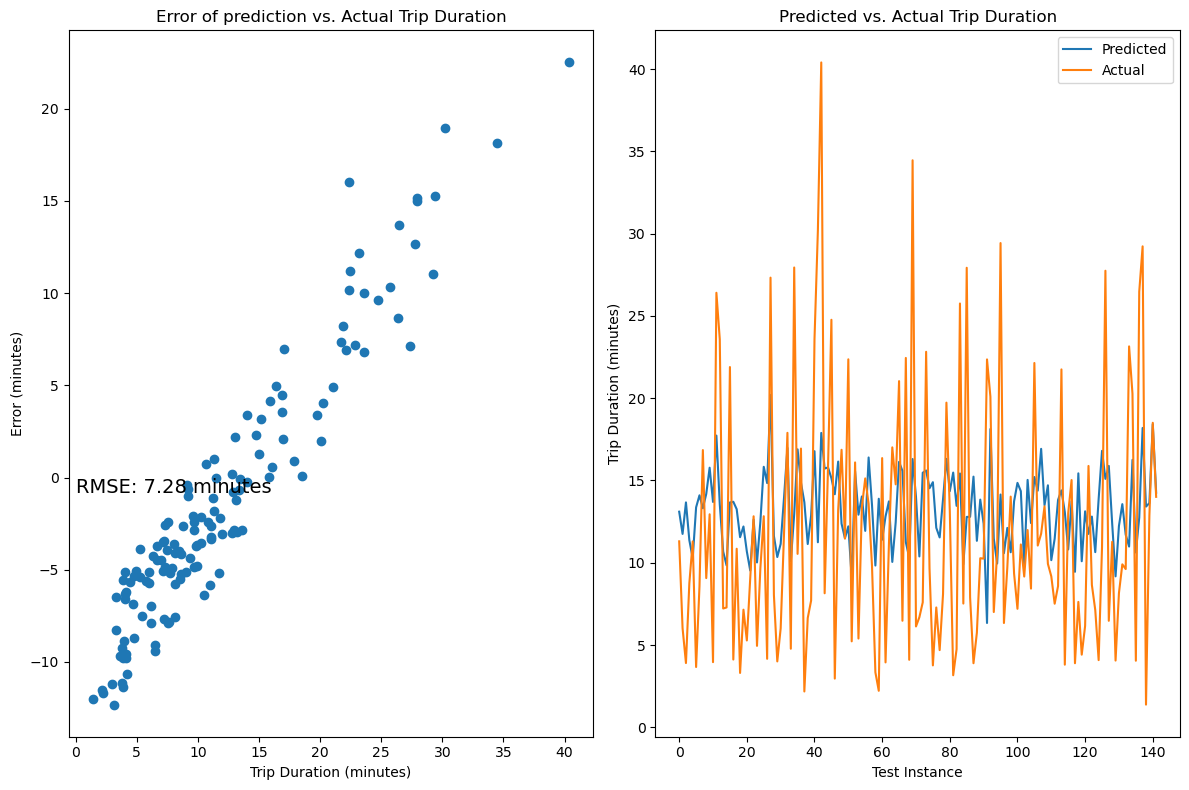

In [40]:
# Plot the error
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.scatter(y_test/60, error/60)
plt.text(0, 0, 'RMSE: {:.2f} minutes'.format(rmse/60), fontsize=14, va='top')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Error (minutes)')
plt.title('Error of prediction vs. Actual Trip Duration')
plt.subplot(1, 2, 2)
plt.plot(y_pred/60, label='Predicted')
plt.plot(y_test.values/60, label='Actual')
plt.xlabel('Test Instance')
plt.ylabel('Trip Duration (minutes)')
plt.title('Predicted vs. Actual Trip Duration')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('plots', 'linear_regression.png'))
plt.show()

Random Forest model for predicting the trip duration

In [41]:
from sklearn.ensemble import RandomForestRegressor

# Fit a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf.predict(X_test)

# Calculate the RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE:', rmse)

RMSE: 275.9047918604936


Print the Random Forest model results

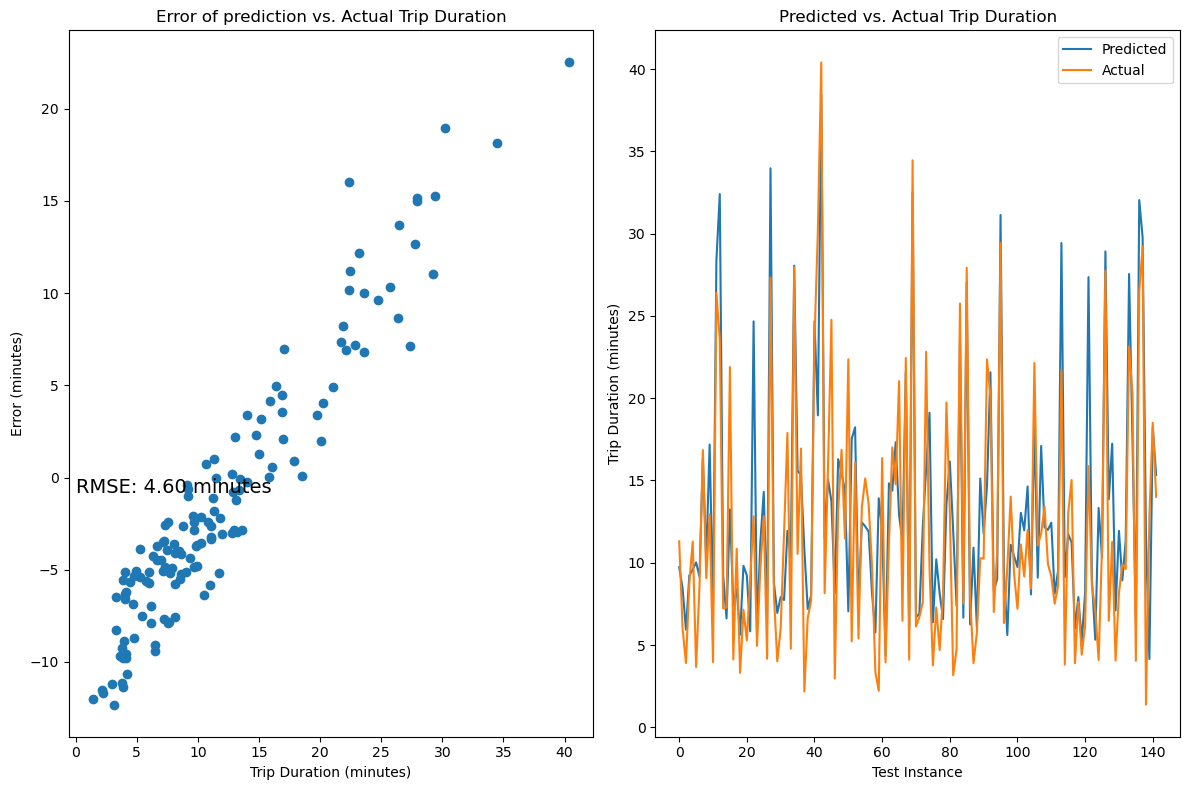

In [42]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.scatter(y_test/60, error/60)
plt.text(0, 0, 'RMSE: {:.2f} minutes'.format(rmse/60), fontsize=14, va='top')
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Error (minutes)')
plt.title('Error of prediction vs. Actual Trip Duration')
plt.subplot(1, 2, 2)
plt.plot(y_pred/60, label='Predicted')
plt.plot(y_test.values/60, label='Actual')
plt.xlabel('Test Instance')
plt.ylabel('Trip Duration (minutes)')
plt.title('Predicted vs. Actual Trip Duration')
plt.legend()
plt.tight_layout()
plt.savefig(os.path.join('plots', 'random_forest.png'))
plt.show()


Implement Linear tranformation in a neural network

Epoch [10/3000], Loss: 901645.6250
Estimated remaining time: 0.28 minutes
Epoch [20/3000], Loss: 899451.4375
Estimated remaining time: 0.18 minutes
Epoch [30/3000], Loss: 896179.8125
Estimated remaining time: 0.14 minutes
Epoch [40/3000], Loss: 891473.6250
Estimated remaining time: 0.13 minutes
Epoch [50/3000], Loss: 884887.9375
Estimated remaining time: 0.12 minutes
Epoch [60/3000], Loss: 875954.9375
Estimated remaining time: 0.11 minutes
Epoch [70/3000], Loss: 864176.0625
Estimated remaining time: 0.11 minutes
Epoch [80/3000], Loss: 849053.5000
Estimated remaining time: 0.11 minutes
Epoch [90/3000], Loss: 830126.1875
Estimated remaining time: 0.10 minutes
Epoch [100/3000], Loss: 806999.1250
Estimated remaining time: 0.10 minutes
Epoch [110/3000], Loss: 779386.1250
Estimated remaining time: 0.10 minutes
Epoch [120/3000], Loss: 747153.6875
Estimated remaining time: 0.09 minutes
Epoch [130/3000], Loss: 710366.0625
Estimated remaining time: 0.09 minutes
Epoch [140/3000], Loss: 669326.875

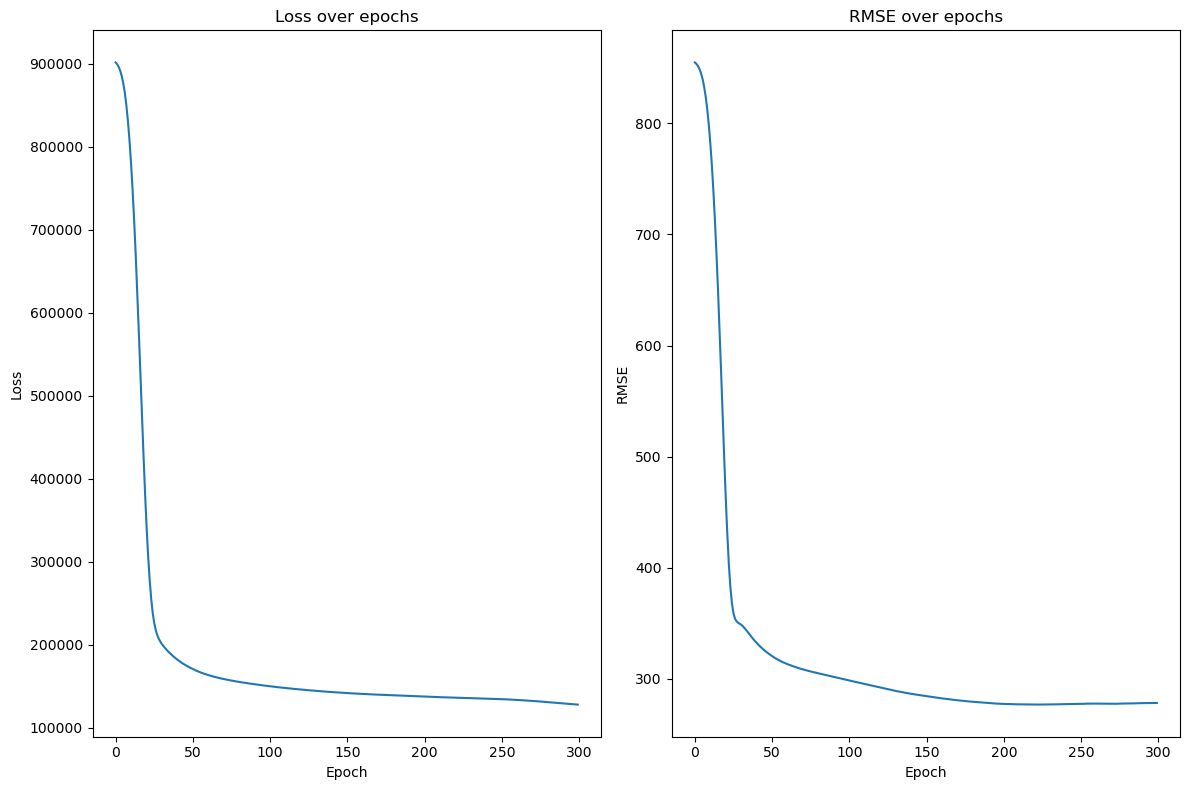

In [43]:
# Extract the features
features = MVC[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'hour']]

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

# Extract the target variable
target = MVC['tripduration']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)

# Check if there is a GPU available else run in CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).to(device)

# Neural Network model
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(128, 64)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        return x
    
model = RegressionModel(input_size=X_train.shape[1])

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Evaluation on the test set
def evaluate(model, X_test_tensor, y_test_tensor):    
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        rmse_nn = torch.sqrt(criterion(y_pred_tensor, y_test_tensor.view(-1, 1)))
        return rmse_nn

# Training the model
epochs = 3000 # Number of epochs
losses = [] # Keep track of the losses over time
rmse_array = []
start_time = time()
for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        losses.append(loss.item())
        rmse_nn = evaluate(model, X_test_tensor, y_test_tensor)
        rmse_array.append(rmse_nn.item())
        # Estimate the remaining time
        remaining_time = (time() - start_time) * (epochs - epoch) / (epoch + 1)
        print(f'Estimated remaining time: {remaining_time/60:.2f} minutes')

# Plot the loss over epochs
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.subplot(1,2,2)
plt.plot(rmse_array)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over epochs')
plt.tight_layout()
plt.savefig(os.path.join('plots', 'neural_network.png'))
plt.show()



In [44]:
min_rmse = np.min(rmse_array)
print('Minimum possible RMSE:', min_rmse)

Minimum possible RMSE: 276.7729187011719


Create a NN with dropout layers

Epoch [10/2000], Loss: 903051.1875
RMSE: 855.6940
Estimated remaining time: 1.86 minutes
Epoch [20/2000], Loss: 903044.3750
RMSE: 855.6586
Estimated remaining time: 1.78 minutes
Epoch [30/2000], Loss: 903037.4375
RMSE: 855.7078
Estimated remaining time: 1.80 minutes
Epoch [40/2000], Loss: 903058.6250
RMSE: 855.6688
Estimated remaining time: 1.73 minutes
Epoch [50/2000], Loss: 903039.3125
RMSE: 855.6717
Estimated remaining time: 1.72 minutes
Epoch [60/2000], Loss: 903048.7500
RMSE: 855.6967
Estimated remaining time: 1.71 minutes
Epoch [70/2000], Loss: 903040.3125
RMSE: 855.6863
Estimated remaining time: 1.69 minutes
Epoch [80/2000], Loss: 903024.6250
RMSE: 855.6705
Estimated remaining time: 1.72 minutes
Epoch [90/2000], Loss: 903031.8750
RMSE: 855.6791
Estimated remaining time: 1.71 minutes
Epoch [100/2000], Loss: 903046.9375
RMSE: 855.6788
Estimated remaining time: 1.69 minutes
Epoch [110/2000], Loss: 903049.9375
RMSE: 855.6757
Estimated remaining time: 1.69 minutes
Epoch [120/2000], L

Epoch [840/2000], Loss: 903033.6875
RMSE: 855.6887
Estimated remaining time: 1.04 minutes
Epoch [850/2000], Loss: 903037.0625
RMSE: 855.6642
Estimated remaining time: 1.03 minutes
Epoch [860/2000], Loss: 903048.0625
RMSE: 855.6957
Estimated remaining time: 1.02 minutes
Epoch [870/2000], Loss: 903033.2500
RMSE: 855.6707
Estimated remaining time: 1.01 minutes
Epoch [880/2000], Loss: 903055.6875
RMSE: 855.6945
Estimated remaining time: 1.01 minutes
Epoch [890/2000], Loss: 903049.0625
RMSE: 855.6674
Estimated remaining time: 1.01 minutes
Epoch [900/2000], Loss: 903057.1875
RMSE: 855.6848
Estimated remaining time: 1.00 minutes
Epoch [910/2000], Loss: 903052.5000
RMSE: 855.6895
Estimated remaining time: 1.00 minutes
Epoch [920/2000], Loss: 903064.4375
RMSE: 855.6746
Estimated remaining time: 0.99 minutes
Epoch [930/2000], Loss: 903032.3125
RMSE: 855.6904
Estimated remaining time: 0.98 minutes
Epoch [940/2000], Loss: 903045.1250
RMSE: 855.6824
Estimated remaining time: 0.98 minutes
Epoch [950

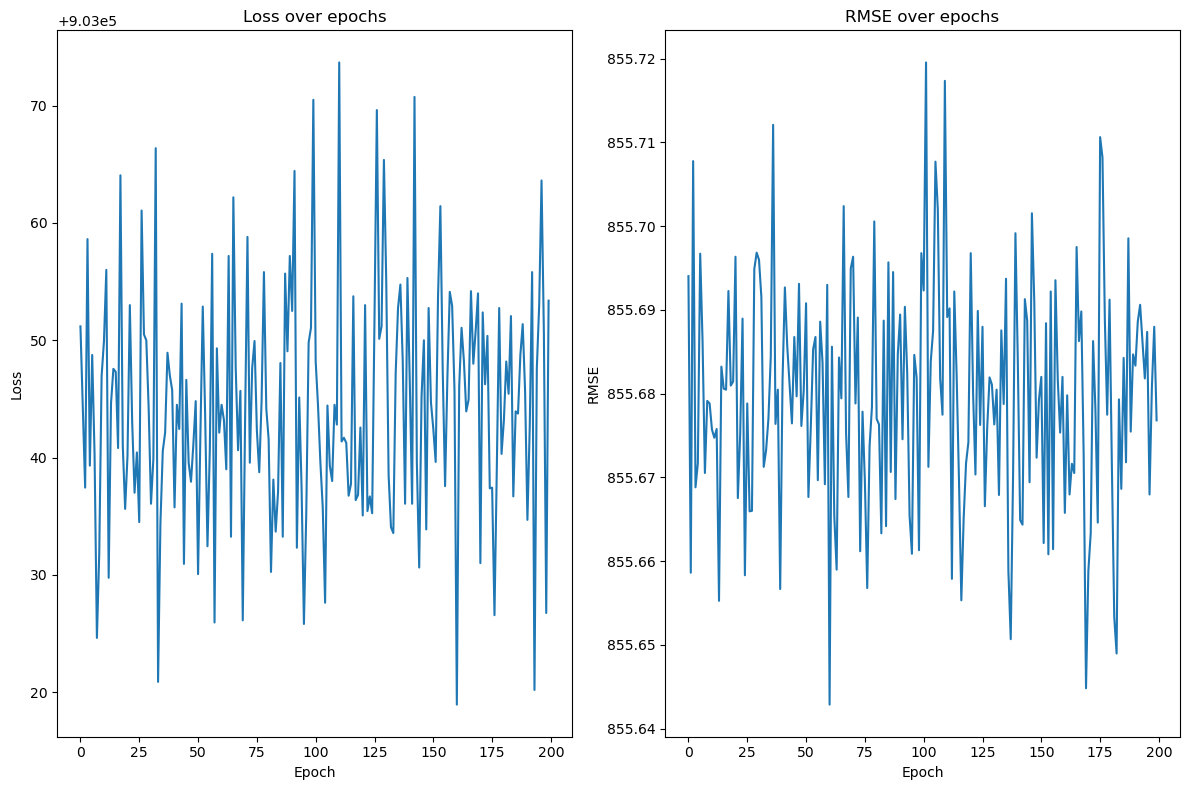

In [45]:
# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# Neural Network model with dropout
class EnhancedRegressionModel(nn.Module):
    def __init__(self, input_size):
        super(EnhancedRegressionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, 2048)
        self.relu1 = nn.LeakyReLU(0.2)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(2048, 1024)
        self.relu2 = nn.LeakyReLU(0.2)
        self.dropout2 = nn.Dropout(0.5)
        self.fc3 = nn.Linear(1024, 512)
        self.relu3 = nn.LeakyReLU(0.2)
        self.dropout3 = nn.Dropout(0.5)
        self.fc4 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Evaluation on the test set
def evaluate(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        rmse_nn = torch.sqrt(criterion(y_pred_tensor, y_test_tensor.view(-1, 1)))
        return rmse_nn

# Training the model
epochs = 2000
losses = []  # Keep track of the losses over time
rmse_array = []
start_time = time()

model = EnhancedRegressionModel(input_size=X_train.shape[1])

for epoch in range(epochs):
    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor.view(-1, 1))

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print progress
    if (epoch + 1) % 10 == 0:
        losses.append(loss.item())
        rmse_nn = evaluate(model, X_test_tensor, y_test_tensor)
        rmse_array.append(rmse_nn.item())
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        print(f'RMSE: {rmse_nn.item():.4f}')
        print(f'Estimated remaining time: {(time() - start_time) * (epochs - epoch) / (epoch + 1)/60:.2f} minutes')

# Plot the loss over epochs
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.subplot(1, 2, 2)
plt.plot(rmse_array)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over epochs')
plt.tight_layout()
plt.savefig(os.path.join('plots', 'neural_network_dropout.png'))
plt.show()


LSTM model for predicting the trip duration (Mike's model)

Epoch [10/2000], Loss: 803978.0000
RMSE: 836.5095
Estimated remaining time: 1.67 minutes


Epoch [20/2000], Loss: 594253.0625
RMSE: 742.7735
Estimated remaining time: 1.63 minutes
Epoch [30/2000], Loss: 622402.9375
RMSE: 621.5584
Estimated remaining time: 1.72 minutes
Epoch [40/2000], Loss: 462236.1562
RMSE: 521.9565
Estimated remaining time: 1.58 minutes
Epoch [50/2000], Loss: 331945.2500
RMSE: 487.9136
Estimated remaining time: 1.62 minutes
Epoch [60/2000], Loss: 300702.0312
RMSE: 471.6250
Estimated remaining time: 1.54 minutes
Epoch [70/2000], Loss: 310916.5938
RMSE: 495.8111
Estimated remaining time: 1.54 minutes
Epoch [80/2000], Loss: 385637.6562
RMSE: 483.6770
Estimated remaining time: 1.54 minutes
Epoch [90/2000], Loss: 425031.3438
RMSE: 490.5226
Estimated remaining time: 1.56 minutes
Epoch [100/2000], Loss: 343726.7500
RMSE: 493.1094
Estimated remaining time: 1.54 minutes
Epoch [110/2000], Loss: 335454.8750
RMSE: 472.2828
Estimated remaining time: 1.50 minutes
Epoch [120/2000], Loss: 363417.8750
RMSE: 497.0228
Estimated remaining time: 1.47 minutes
Epoch [130/2000], 

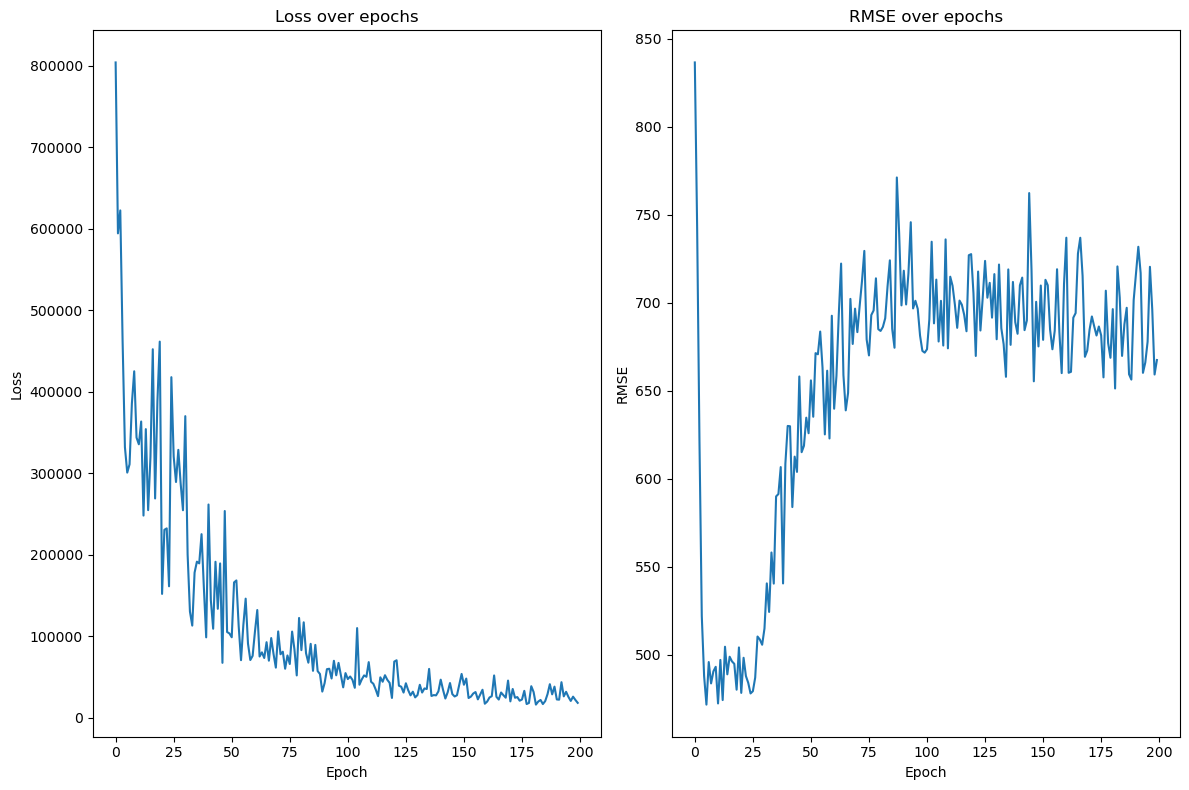

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

features = MVC[['start_station_latitude', 'start_station_longitude', 'end_station_latitude', 'end_station_longitude', 'hour']]
target = MVC['tripduration']
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Convert the data into sequences
def create_sequences(input_data, target_data, seq_length):
    sequences = []
    target_sequences = []
    for i in range(len(input_data) - seq_length):
        seq = input_data[i:i+seq_length]
        # Using .iloc to access elements by position
        target_seq = target_data.iloc[i + seq_length]  
        sequences.append(seq)
        target_sequences.append(target_seq)
    return np.array(sequences), np.array(target_sequences)

sequence_length = 5
X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Convert to tensors and move to the chosen device
X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32).to(device).view(-1, 1)
X_test_seq = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_seq = torch.tensor(y_test_seq, dtype=torch.float32).to(device).view(-1, 1)

# Create DataLoader instances
batch_size = 64
train_dataset = TensorDataset(X_train_seq, y_train_seq)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_seq, y_test_seq)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.lstm2 = nn.LSTM(hidden_layer_size, hidden_layer_size, batch_first=True)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.linear1 = nn.Linear(hidden_layer_size, 64)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(64, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm1(x)
        lstm_out = self.dropout1(lstm_out)
        lstm_out, _ = self.lstm2(lstm_out)
        lstm_out = self.dropout2(lstm_out)
        lstm_out = lstm_out[:, -1, :]
        out = self.linear1(lstm_out)
        out = self.relu(out)
        predictions = self.linear2(out)
        return predictions

model = LSTMModel(input_size=5, hidden_layer_size=50, output_size=1, dropout_rate=0.5)
model.to(device)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training the LSTM model
# Evaluation on the test set
def evaluate(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        rmse_nn = torch.sqrt(criterion(y_pred_tensor, y_test_tensor.view(-1, 1)))
        return rmse_nn

# Training the model
epochs = 2000
losses = []  
rmse_array = []
start_time = time()  
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

    # Save the loss and RMSE for plotting every 10 epochs
    if (epoch + 1) % 10 == 0:
        losses.append(loss.item())
        rmse_nn = evaluate(model, X_test_seq, y_test_seq)
        rmse_array.append(rmse_nn.item())
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
        print(f'RMSE: {rmse_nn.item():.4f}')
        print(f'Estimated remaining time: {(time() - start_time) * (epochs - epoch) / (epoch + 1)/60:.2f} minutes')


# Plot the loss and RMSE over epochs
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.subplot(1, 2, 2)
plt.plot(rmse_array)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over epochs')
plt.tight_layout()
plt.savefig(os.path.join('plots', 'lstm_pytorch.png'))
plt.show()

# Save the model
torch.save(model.state_dict(), 'lstm_pytorch_model.pth')


In [47]:
MVC.info()

<class 'pandas.core.frame.DataFrame'>
Index: 707 entries, 10376436 to 14863760
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   tripduration             707 non-null    float64       
 1   starttime                707 non-null    datetime64[ns]
 2   stoptime                 707 non-null    datetime64[ns]
 3   start_station_id         707 non-null    float64       
 4   start_station_latitude   707 non-null    float64       
 5   start_station_longitude  707 non-null    float64       
 6   end_station_id           707 non-null    float64       
 7   end_station_latitude     707 non-null    float64       
 8   end_station_longitude    707 non-null    float64       
 9   bikeid                   707 non-null    int64         
 10  usertype                 707 non-null    object        
 11  birth_year               707 non-null    int64         
 12  gender                   707 

In [49]:
# Convert start and stop times to datetime
MVC['starttime'] = pd.to_datetime(df['starttime'])
MVC['stoptime'] = pd.to_datetime(df['stoptime'])

# Extract hour and date from start and stop times
MVC['start_hour'] = MVC['starttime'].dt.hour
MVC['start_date'] = MVC['starttime'].dt.date
MVC['stop_hour'] = MVC['stoptime'].dt.hour
MVC['stop_date'] = MVC['stoptime'].dt.date

# Aggregate data by hour and station for pickups
hourly_pickups = MVC.groupby(['start_station_id', 'start_date', 'start_hour']).size().reset_index(name='pickups')

# Aggregate data by hour and station for drop-offs
hourly_dropoffs = MVC.groupby(['end_station_id', 'stop_date', 'stop_hour']).size().reset_index(name='dropoffs')

#Handling missing data
# Create a complete range of hours and dates for the dataset
all_hours = pd.date_range(df['starttime'].min(), df['stoptime'].max(), freq='H')
all_stations = MVC['start_station_id'].unique()

# Create a complete DataFrame of hours and stations
complete_data = pd.MultiIndex.from_product([all_stations, all_hours], names=['station_id', 'hour']).to_frame(index=False)

# Convert 'hour' to separate date and hour columns
complete_data['date'] = complete_data['hour'].dt.date
complete_data['hour'] = complete_data['hour'].dt.hour

# Now merge this with the actual data
complete_pickups = pd.merge(complete_data, hourly_pickups, how='left', left_on=['station_id', 'date', 'hour'], right_on=['start_station_id', 'start_date', 'start_hour'])
complete_dropoffs = pd.merge(complete_data, hourly_dropoffs, how='left', left_on=['station_id', 'date', 'hour'], right_on=['end_station_id', 'stop_date', 'stop_hour'])

# Fill missing values with 0
complete_pickups['pickups'].fillna(0, inplace=True)
complete_dropoffs['dropoffs'].fillna(0, inplace=True)
# Merge the pickups and dropoffs data
hourly_data = pd.merge(complete_pickups[['station_id', 'date', 'hour', 'pickups']], complete_dropoffs[['station_id', 'date', 'hour', 'dropoffs']], on=['station_id', 'date', 'hour'])

In [50]:
hourly_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 349680 entries, 0 to 349679
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   station_id  349680 non-null  float64
 1   date        349680 non-null  object 
 2   hour        349680 non-null  int32  
 3   pickups     349680 non-null  float64
 4   dropoffs    349680 non-null  float64
dtypes: float64(3), int32(1), object(1)
memory usage: 12.0+ MB


/tmp/ipykernel_74693/1915966445.py:24: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_74693/1915966445.py:25: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_74693/1915966445.py:26: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_74693/1915966445.py:27: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Training the model...
Epoch [10/2000], Loss: 641801.6875
RMSE: 859.7407
Estimated remaining time: 1.14 minutes
Epoch [10/2000], Loss: 675808.2500
RMSE: 859.7462
Estimated remaining time: 1.15 minutes
Epoch [10/2000], Loss: 914604.0000
RMSE: 859.6310
Estimated remaining time: 1.16 minutes
Epoch [10/2000], Loss: 1093142.1250
RMSE: 859.5175
Estimated remaining time: 1.18 minutes
Epoch [10/2000], Loss: 826224.2500
RMSE: 859.5147
Estimated remaining time: 1.19 minutes
Epoch [10/2000], Loss: 1096893.3750
RMSE: 859.6580
Estimated remaining time: 1.20 minutes
Epoch [10/2000], Loss: 910824.3125
RMSE: 859.4238
Estimated remaining time: 1.21 minutes
Epoch [10/2000], Loss: 832297.8125
RMSE: 859.1511
Estimated remaining time: 1.23 minutes
Epoch [10/2000], Loss: 1096321.0000
RMSE: 859.1737
Estimated remaining time: 1.24 minutes
Epoch [20/2000], Loss: 905527.5625
RMSE: 854.0672
Estimated remaining time: 1.13 minutes
Epoch [20/2000], Loss: 891889.8750
RMSE: 854.2327
Estimated remaining time: 1.14 minu

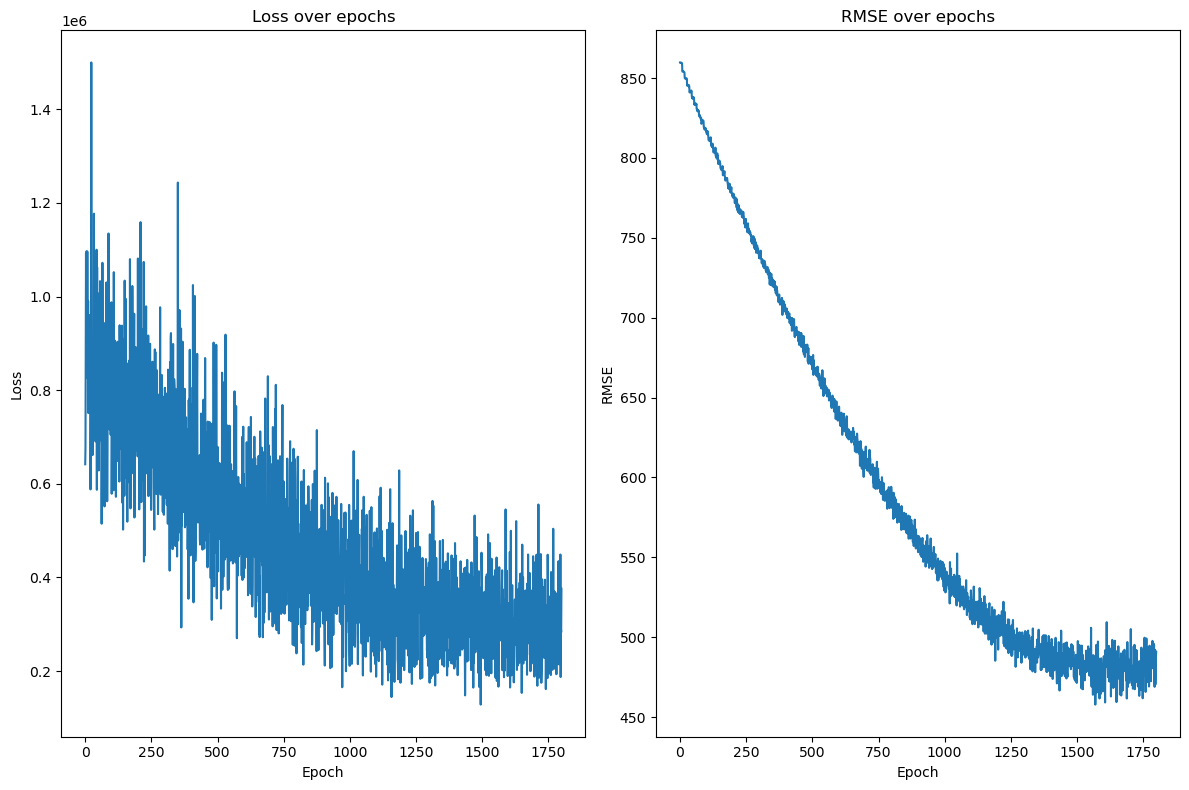

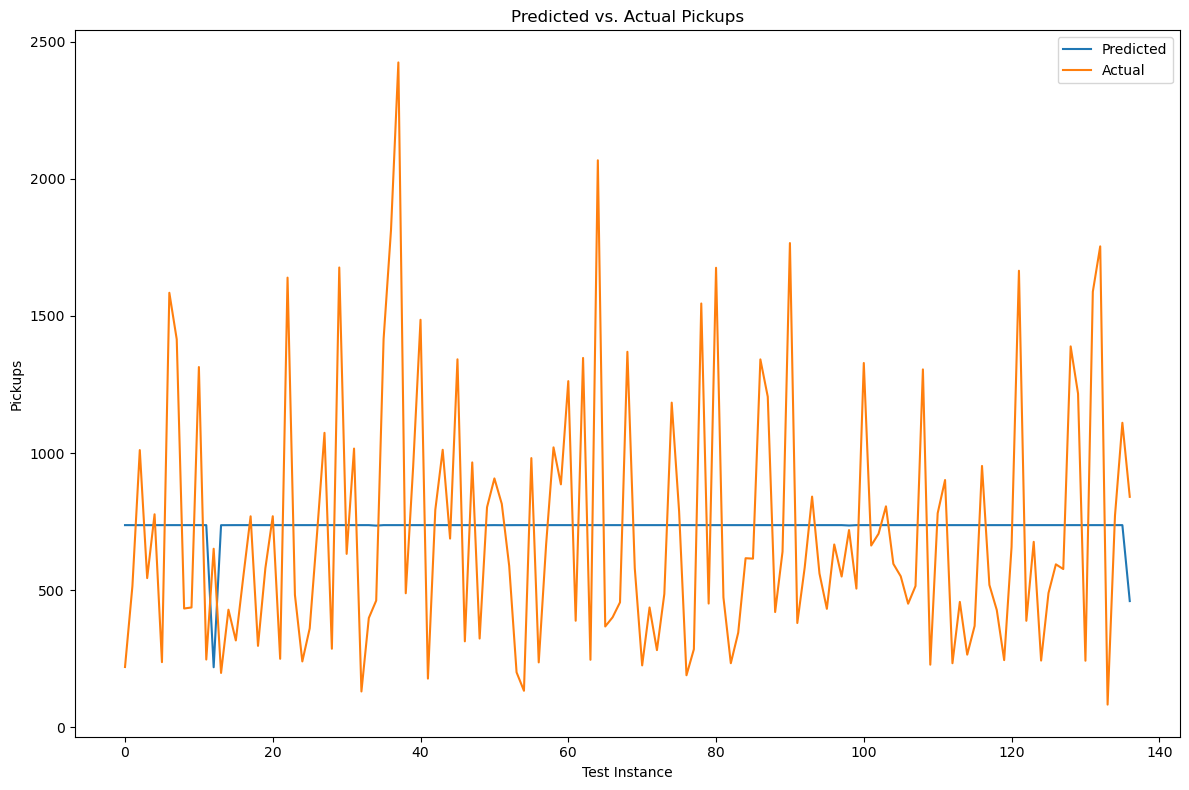

In [53]:
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch.nn as nn
import torch.optim as optim

# Prepare the data
features = hourly_data[['station_id', 'date', 'hour']]
target = hourly_data['pickups']

# Convert categorical features to one-hot encoding
features_encoded = pd.get_dummies(features, columns=['station_id', 'date', 'hour'])

# Standardize the features
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features_encoded)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features_standardized, target, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.float32).to(device).view(-1, 1)
X_test_tensor = torch.tensor(X_test_seq, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test_seq, dtype=torch.float32).to(device).view(-1, 1)


# Create DataLoader instances
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, dropout_rate=0.5):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_layer_size, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        lstm_out = self.dropout(lstm_out[:, -1, :])
        predictions = self.linear(lstm_out)
        return predictions

# Set the hyperparameters
input_size = X_train.shape[1]
hidden_layer_size = 50
output_size = 1
dropout_rate = 0.5
learning_rate = 0.001
epochs = 2000

# Create the LSTM model
model = LSTMModel(input_size, hidden_layer_size, output_size, dropout_rate)

# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

rmse_array = []
start_time = time()
losses = []
# Evaluation on the test set
def evaluate(model, X_test_tensor, y_test_tensor):
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        rmse_nn = torch.sqrt(criterion(y_pred_tensor, y_test_tensor.view(-1, 1)))
        return rmse_nn
    
# Training the LSTM model
print('Training the model...')
for epoch in range(epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch.view(-1, 1))
        loss.backward()
        optimizer.step()

    # Print progress
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}')
            rmse_nn = evaluate(model, X_test_tensor, y_test_tensor)
            losses.append(loss.item())
            rmse_array.append(rmse_nn.item())
            print(f'RMSE: {rmse_nn.item():.4f}')
            print(f'Estimated remaining time: {(time() - start_time) * (epochs - epoch) / (epoch + 1)/60:.2f} minutes')

# Plot the loss and RMSE over epochs
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over epochs')
plt.subplot(1, 2, 2)
plt.plot(rmse_array)
plt.xlabel('Epoch')
plt.ylabel('RMSE')
plt.title('RMSE over epochs')
plt.tight_layout()
plt.savefig(os.path.join('plots', 'lstm_pytorch_pickups.png'))
plt.show()

# Save the model
torch.save(model.state_dict(), 'lstm_pytorch_pickups_model.pth')

# Plot the predictions vs. actual
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred = y_pred_tensor.cpu().numpy()
    y_test = y_test_tensor.cpu().numpy()
    plt.figure(figsize=(12, 8))
    plt.plot(y_pred, label='Predicted')
    plt.plot(y_test, label='Actual')
    plt.xlabel('Test Instance')
    plt.ylabel('Pickups')
    plt.title('Predicted vs. Actual Pickups')
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join('plots', 'lstm_pytorch_pickups_predictions.png'))
    plt.show()

#
